<a href="https://colab.research.google.com/github/subornaa/Data-Analytics-Tutorials/blob/main/Geospatial_Data_Tutorials.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Geospatial Data Analysis in Python

<img src = 'https://drive.google.com/uc?id=1WC7SSdfFseYRgmZ6lbodv898zi2nquJ0' width = 80%>

## Introduction and Dataset Background

### Geospatial Data

In this tutorial, we will explore the three main types of spatial data:

1) Raster

2) Vector

3) Point Cloud (i.e., 3D data)

The tutorial makes use of the Petawawa Research Forest (PRF) data, which is described in more detail in on the tutorial series [GitHub site](https://github.com/subornaa/Data-Analytics-Tutorials).

### Tutorial goals

This tutorial has several goals, motivated by the aformentioned data types.

**Goal 1: Summarize the coverage of different water bodies within the PRF and provide summary statistics.**

**Goal 2: Analyze the LiDAR-derived 99th height percentile raster and compare this height with plot level tree height measurements.**

**Goal 3: Calculate NDVI, NDMI, and NBR spectral indices using Sentinel-2 imagery and compare indices from 2018 and 2024 to assess forest change.**

**Goal 4: Perform height normalization on a subset of LiDAR point cloud data and analyze the forest structure from a 3-D perspective**

-----

**Notes:**

- Spectral indices are frormulas used to highlight specific patterns in spectral data using multiple bands. The indices relevant for this analysis include 1) Normalized Difference Vegetation Index (NDVI); 2) Normalized Difference Moisture Index (NDMI); 3) Normalized Burn Ratio (NBR). See this [guide for Sentinel-2 spectral indices](https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel/sentinel-2/) for more information.

- Goal 4 relates to processing LiDAR point cloud data. This is a common task in forestry, and is typically executed using a variety of software including the [lidR package](https://r-lidar.github.io/lidRbook/) and [LAStools](https://lastools.github.io/). We will base methods in this tutorial for point cloud height normalization on those implemented in the lidR package.

### Dataset description

#### File Formats

Different spatial data types have different file formats. This is due to the way each data type is organized. Raster data is stored as a grid (array) format, and can be stored efficiently in formats such as GeoTIFF (.tif). In contrast, vector data is continuous and more complex, meaning it requires different file formats such as shapefile (.shp) or GeoPackage (.gpkg). Finally, LiDAR data is the most dense data format, with point clouds often containing millions of points, each with XYZ coordinates and additional attributes. Point cloud data derived from LiDAR sensors  is typically stored in .las or .laz formats.

#### Files

The following files are used in this tutorial:

- `plots.pgkg`
- `trees.csv`
- `boundary.gpkg`
- `water.gpkg`
- `p99.tif`
- `petawawa_s2_2018.tif`
- `petawawa_s2_2024.tif`
- `forest_point_cloud.las`
- `forest_point_cloud_footprint.gpkg`

Please refer to the README on the main GitHub page for a detailed description of each file.

### Packages

Due to the different file formats and data characteristics, each spatial data type has its own corresponding packages used for reading, writting, and processing in python.

While there are many packages available for each data type, we will use the following three in this tutorial:

**Raster: [rioxarray](https://corteva.github.io/rioxarray/stable/index.html)**

**Vector: [geopandas](https://geopandas.org/en/stable/)**

**Point Cloud: [laspy](https://laspy.readthedocs.io/en/latest/)**



# Install and load packages

**Uncomment the cell below to install required packages**

In [38]:
# !pip install pandas==2.2.2
# !pip install geopandas==1.0.1
# !pip install matplotlib==3.10.1
# !pip install rioxarray==0.19.0
# !pip install laspy[lazrs]==2.5.4

In [39]:
import os
import geopandas as gpd
import rioxarray as rio
import matplotlib.pyplot as plt
import laspy
import numpy as np
from matplotlib.patches import Patch
from rasterio.plot import show, reshape_as_image
from rasterio.plot import show

# Download data

In [40]:
# Download the data if it does not yet exist
if not os.path.exists("data"):
  !gdown 1UDKAdXW0h6JSf7k31PZ-srrQ3487l9e2
  !unzip prf_data.zip -d data/
  os.remove("prf_data.zip")
else:
  print("Data has already been downloaded.")

os.listdir("data")

Data has already been downloaded.


['als_metrics.tif',
 'boundary.gpkg',
 'forest_point_cloud.las',
 'forest_point_cloud_footprint.gpkg',
 'original',
 'petawawa_s2_2018.tif',
 'petawawa_s2_2024.tif',
 'plots.gpkg',
 'trees.csv',
 'water.gpkg']

# Visualization

**A great place to begin when working with any spatial data is visualization**

Note: in some cases the dataset may be too massive to visualize quickly/easily. In such cases, the data may need to be subset prior to visualizing.

In [41]:
# Load the airborne laser scanning (ALS) metrics raster data
als_metrics = rio.open_rasterio(r'data/als_metrics.tif')
als_metrics

<xarray.DataArray (band: 67, y: 366, x: 746)> Size: 73MB
[18293412 values with dtype=float32]
Coordinates:
  * band         (band) int64 536B 1 2 3 4 5 6 7 8 9 ... 60 61 62 63 64 65 66 67
  * x            (x) float64 6kB 2.974e+05 2.974e+05 ... 3.16e+05 3.16e+05
  * y            (y) float64 3kB 5.099e+06 5.099e+06 ... 5.09e+06 5.09e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     -3.4028235e+38
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      ('avg_95_T0', 'avg_T0', 'b10_T0cm_49', 'b20_T0cm_49', 'b3...

In [42]:
# View the band names
band_id_ls = list(enumerate(als_metrics.long_name))
band_id_ls = [str(nm) for nm in band_id_ls]
print("\n".join(band_id_ls))


(0, 'avg_95_T0')
(1, 'avg_T0')
(2, 'b10_T0cm_49')
(3, 'b20_T0cm_49')
(4, 'b30_T0cm_49')
(5, 'b40_T0cm_49')
(6, 'b50_T0cm_49')
(7, 'b60_T0cm_49')
(8, 'b70_T0cm_49')
(9, 'b80_T0cm_49')
(10, 'b90_T0cm_49')
(11, 'density_T10m')
(12, 'density_T12m')
(13, 'density_T14m')
(14, 'density_T15m')
(15, 'density_T16m')
(16, 'density_T18m')
(17, 'density_T20m')
(18, 'density_T25m')
(19, 'density_T2m')
(20, 'density_T4m')
(21, 'density_T5m')
(22, 'density_T6m')
(23, 'density_T8m')
(24, 'kur_95_T0')
(25, 'p01_T0')
(26, 'p05_T0')
(27, 'p10_T0')
(28, 'p20_T0')
(29, 'p30_T0')
(30, 'p40_T0')
(31, 'p50_T0')
(32, 'p60_T0')
(33, 'p70_T0')
(34, 'p80_T0')
(35, 'p90_T0')
(36, 'p95_T0')
(37, 'p99_T0')
(38, 'qav_T0')
(39, 'skew_95_T0')
(40, 'slice0_2_T0')
(41, 'slice10_12_T0')
(42, 'slice12_14_T0')
(43, 'slice14_16_T0')
(44, 'slice16_18_T0')
(45, 'slice18_20_T0')
(46, 'slice20_22_T0')
(47, 'slice22_24_T0')
(48, 'slice24_26_T0')
(49, 'slice26_28_T0')
(50, 'slice28_30_T0')
(51, 'slice2_4_T0')
(52, 'slice30_32_T0')


In [43]:
# Subset the 99th height percentile band
p99 = als_metrics[37]
p99

<xarray.DataArray (y: 366, x: 746)> Size: 1MB
[273036 values with dtype=float32]
Coordinates:
    band         int64 8B 38
  * x            (x) float64 6kB 2.974e+05 2.974e+05 ... 3.16e+05 3.16e+05
  * y            (y) float64 3kB 5.099e+06 5.099e+06 ... 5.09e+06 5.09e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     -3.4028235e+38
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      ('avg_95_T0', 'avg_T0', 'b10_T0cm_49', 'b20_T0cm_49', 'b3...

[]

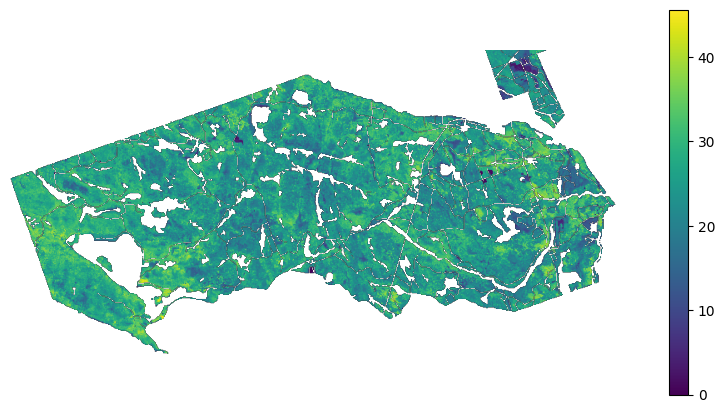

In [44]:
# Raster data: Visualize the LiDAR-derived 99th height percentile of the PRF
fig, ax = plt.subplots(figsize=(10, 5))

cmap = 'viridis'

image_hidden = ax.imshow(p99, cmap=cmap)

show(p99, ax=ax, cmap=cmap)

fig.colorbar(image_hidden, ax=ax)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.set_xticks([])
ax.set_yticks([])


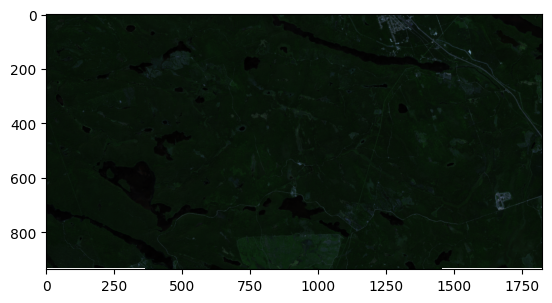

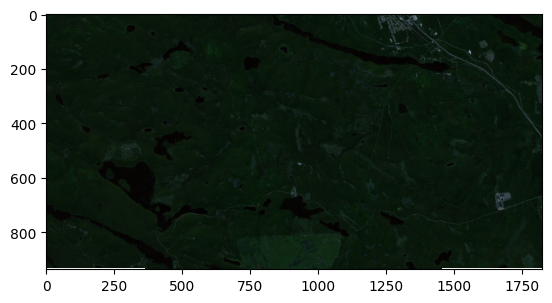

<Axes: >

In [45]:
# Raster data: Visualize the Sentinel-2 Imagery

s2_2018 = rio.open_rasterio(r'data/petawawa_s2_2018.tif')
s2_2024 = rio.open_rasterio(r'data/petawawa_s2_2024.tif')

# S2 raster data has 12 bands. Bands 2 - 4 are blue-green-red (RGB; recall that python is 0-indexed though)
    # B2 = Blue
    # B3 = Green
    # B4 = Red

# Note that when S2 bands are plotted, the image appears quite dark since some pixels (i.e., water)...
# ... are very dark, making the rest of the image appear dark as well.
show(s2_2018.values[1:4], adjust=True)
show(s2_2024.values[1:4], adjust=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.022377571983095267..3.807442177700348].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.024200516558000967..3.2938633934986203].


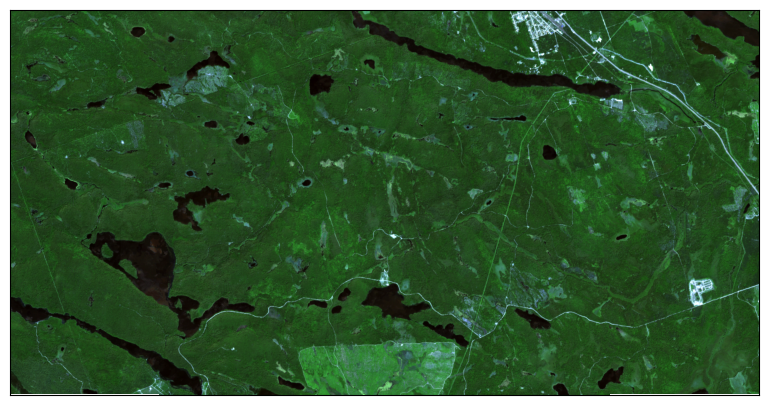

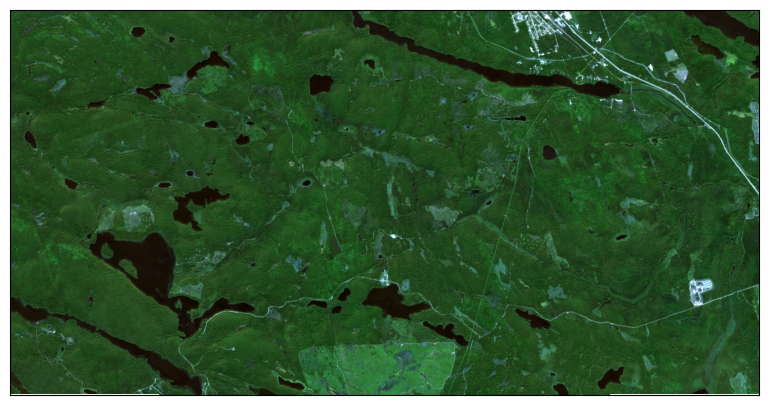

In [46]:
# We can apply a contrast stretch to the image to make it more visually appealing.

def plot_rgb(ras, low_perc=1, high_perc=99):
    """
    Function to plot raster with band order blue, green, red.
    Contrast stretching can be applied using low_perc and high_perc.

    :param: ras: The image to plot.
    :param: low_perc: The lower percentile for contrast stretching.
    :param: high_perc: The upper percentile for contrast stretching.
    """

    img = reshape_as_image(ras)

    fig, ax = plt.subplots(figsize=(10, 5))

    ax.set_xticks([])
    ax.set_yticks([])

    vmin, vmax = np.nanpercentile(img, (low_perc, high_perc))

    img = (img - vmin) / (vmax - vmin)

    plt.imshow(img, vmin=vmin, vmax=vmax)

plot_rgb(s2_2018.values[1:4], low_perc=0.1, high_perc=99.9)
plot_rgb(s2_2024.values[1:4], low_perc=0.1, high_perc=99.9)

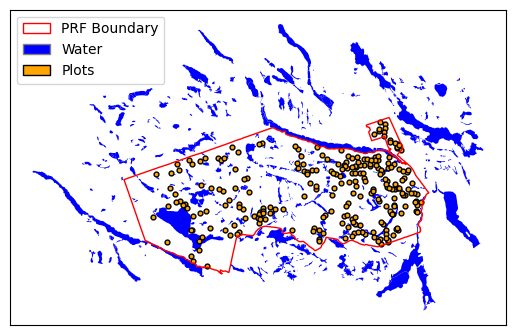

In [47]:
# Vector data: Visualize the plots and PRF boundary

plots_gdf = gpd.read_file(r'data/plots.gpkg')
boundary_gdf = gpd.read_file(r'data/boundary.gpkg')
water_gdf = gpd.read_file(r'data/water.gpkg')

ax = water_gdf.plot(color = 'blue')
plots_gdf.plot(ax = ax, facecolor='orange', edgecolor='black', markersize=12)
boundary_gdf.plot(ax = ax, facecolor = 'none', edgecolor = 'red')

legend_items = [Patch(facecolor='none', edgecolor='r', label='PRF Boundary'),
                Patch(facecolor='blue', edgecolor='grey', label='Water'),
                Patch(facecolor='orange', edgecolor='black', label='Plots')]

ax.legend(handles=legend_items, loc='upper left')
ax.set_xticks([])
ax.set_yticks([])


plt.show()


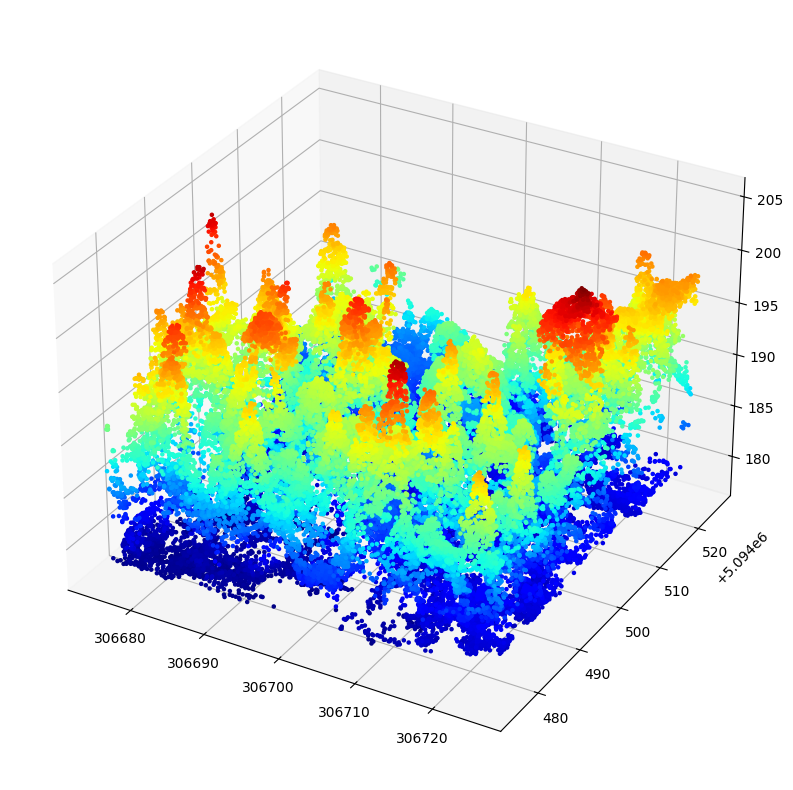

In [48]:
# Point Cloud (3D data): Visualize the LiDAR point cloud

las = laspy.read(r'data/forest_point_cloud.las')

pc = np.vstack([las.x, las.y, las.z]).transpose()

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

ax.scatter(pc[:, 0],
            pc[:, 1],
            pc[:, 2],
            c=pc[:, 2],
            cmap='jet',
            linewidth=1,
            alpha=1,
            s=5)

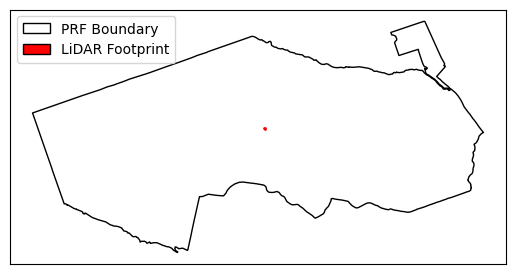

In [49]:
# View the lidar footprint within the PRF

lidar_footprint = gpd.read_file(r'data/forest_point_cloud_footprint.gpkg')

boundary_gdf = gpd.read_file(r'data/boundary.gpkg')

ax = boundary_gdf.plot(facecolor = 'none', edgecolor = 'black')
lidar_footprint.plot(ax = ax, edgecolor='red', markersize=12, linewidth=2)


legend_items = [Patch(facecolor='none', edgecolor='black', label='PRF Boundary'),
                Patch(facecolor='red', edgecolor='black', label='LiDAR Footprint')]

ax.legend(handles=legend_items, loc='upper left')
ax.set_xticks([])
ax.set_yticks([])


plt.show()

# Analysis

## Goal 1: Summarize Water Bodies

## Goal 2: Compare LiDAR with Plot Measurements

## Goal 3: Compare Spectral Indices between 2018 and 2024

## Goal 4: Analyze 3D LiDAR Point Cloud